# Adversarial Machine Learning: Attacking AMSI Providers

Welcome to this years workshop! We are excited to take you on a journey of exploration through the wonderful world of adversarial machine learning. There will be laughing, crying, and hopefully some success. Enjoy <3 

-AIV 

# 1. Introduction
Adversarial Machine Learning (AML) can take many forms, but it is effectively the process of "hacking" a neural network. This could be to gain a [favorable score on a spam email](https://github.com/moohax/Proof-Pudding); bypassing an [endpoint protection product](https://skylightcyber.com/2019/07/18/cylance-i-kill-you/); getting a model to [give away private information](https://arxiv.org/abs/1910.12366); or generally getting the model to behave in unexpected ways either through technical exploitation, mathematics or both! The sky is the limit and machine learning is ripe for the proverbial picking in terms of challenging assumptions and implementations. 

In this workshop we're going to explore how one might go about bypassing the super-duper-next-gen AMSI provider Windows Defender. Currently, most AV bypass technques are static and attackers tend to pile into a technique until it no longer works. This is useful against static or even heuristics detections, but what about against a system that learns? In the not so distant future, attackers will need to create more robust techniques in the face of a system that learns. Excited? Me too, this is brand new research and works against any number of products! Alright, here's the plan,

1. Talk a little bit about the Anti-Malware Scan Interface (AMSI).
2. Introduce and explore our dataset
3. Get into some pre-processing
4. Next, we will prepare the dataset for training
5. Then build and train our model
6. And finally, we will explore the copy-cat and see what comes out the other end!

Let's get to it!

# 2. Anti-Malware-Scan-Interface (AMSI) Providers
Before we can get to Windows Defender we need to introduce AMSI - I'm gonna save you a click here and bring in some information from Microsoft,

>The Windows Antimalware Scan Interface (AMSI) is a versatile interface standard that allows your applications and services to integrate with any antimalware product that's present on a machine. AMSI provides enhanced malware protection for your end-users and their data, applications, and workloads. AMSI is agnostic of antimalware vendor; it's designed to allow for the most common malware scanning and protection techniques provided by today's antimalware products that can be integrated into applications. It supports a calling structure allowing for file and memory or stream scanning, content source URL/IP reputation checks, and other techniques.

The implementation is a DLL (amsi.dll) that gets called into PowerShell, UAC dialogs, JScript, VBScript, and .NET 4.8 whenever they are executed (more specifically, when particular functions are executed). After amsi.dll has been loaded, the `AmsiScanBuffer()` and `AmsiScanString()` methods are responsible for collecting the relevant content and passing it back through RPC to an AMSI provider. 

An AMSI provider represents a security product that has the opportunity to inspect content given to it by AMSI. The provider is free to analyze the content in any way they like (machine learning), but should return a value between `0` and `32768`. The larger the number, the "riskier" the content. A result that is equal to or larger than `32768` is considered malware, in this case AMSI will return [`AmsiResultIsMalware`](https://docs.microsoft.com/en-us/windows/win32/api/amsi/ne-amsi-amsi_result) and execution will be stopped. Currently Defender returns either a `0` or a `32768`, but a range of scores is possible for future updates.

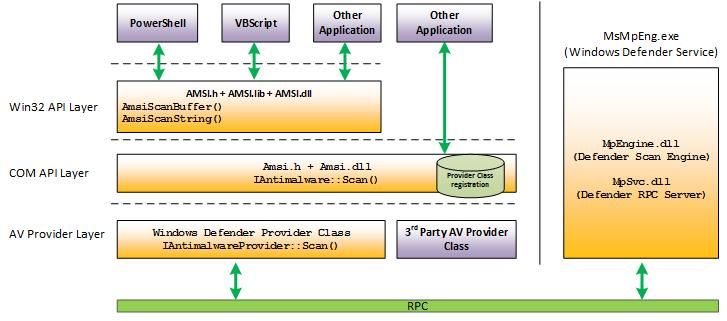

It should be mentioned that Microsoft does not consider AMSI to be a security boundry, this makes sense as it is simply an interface to a provider, so "bypassing AMSI" is perhaps a strange term. However, there are a number of [public AMSI "bypasses"](https://github.com/S3cur3Th1sSh1t/Amsi-Bypass-Powershell) floating around on the internet. Most techniques rely on patching memory such that AMSI has no or incomplete content to scan. Memory patching is effective because amsi.dll is loaded into the same process space as a piece of malware, and as there are no privilege boundries intra-process, a piece of malware is free to make memory modifcations.

For our attack, Defender was a natural choice as it is native on Windows and known to implement machine learning as a detection mechanism. To get more information on how Windows Defender integrates machine learning into malware detection, watch this presentation ["Badly Behaving Scripts"](https://www.youtube.com/watch?v=wvOlHbTU0Ew) from the Microsoft team.

# 3. Formulation
To create a "copy-cat" model of Windows Defender, we need Defender to label a dataset of our choosing ideally something the Defender model is already trained on. Then train our own model to match the labels Windows Defender gave our original dataset.

First we're going to need a dataset. Fortunately, there is a large repository of PowerShell scripts that were made public from Lee Holmes and Daniel Bohanans talk, ["Revoke-Obfuscation: PowerShell Obfuscation Detection Using Science"](https://www.blackhat.com/docs/us-17/thursday/us-17-Bohannon-Revoke-Obfuscation-PowerShell-Obfuscation-Detection-And%20Evasion-Using-Science-wp.pdf) from Blackhat 2017. For this attack, only the [PowerShell scripts](https://onedrive.live.com/?authkey=%21AC9cbXs%2DtwuSZ%2DE&cid=7874CFD565B38D4B&id=7874CFD565B38D4B%211091892&parId=7874CFD565B38D4B%211091891&action=locate) found in the GitHub project folder (383.7k files) were used - but we defintely have multiple copies just in case it gets taken down. The best part about this corpus is that it has both malicious and non-malicious files in it, which means we can learn something from the difference in the output from Defender based on the scripts (inputs).

As attackers, we often don't have access to large datasets and collecting large amounts of data can be operationally expensive, so when you find a [large repository of something interesting](https://figshare.com/articles/Enron_Spreadsheets_and_Emails/1221767) keep it! More generally, as machine learning attacks become more prevalent, expect free data to be a thing of the past.

## 3.1 Data Collection
To get a labelled dataset, we submitted each PowerShell script to Defender via a [custom AMSI integration](https://github.com/microsoft/Windows-classic-samples/tree/master/Samples/AmsiStream). After Defender had returned with a score, we collected the score and stored it in a file along side some other information about the script. The output of the `AmsiStream.exe` program is below. Take a few seconds to review it. 

```bash
> .\AmsiStream.exe "Invoke-WmiBackdoor.ps1"
    Creating stream object with file name: Invoke-WmiBackdoor.ps1
    Calling antimalware->Scan() ...
    GetAttribute() called with: attribute = 0, bufferSize = 1
    GetAttribute() called with: attribute = 0, bufferSize = 68
    GetAttribute() called with: attribute = 1, bufferSize = 1
    GetAttribute() called with: attribute = 1, bufferSize = 46
    GetAttribute() called with: attribute = 2, bufferSize = 8
    GetAttribute() called with: attribute = 3, bufferSize = 8
    Read() called with: position = 0, size = 11250
    GetAttribute() called with: attribute = 4, bufferSize = 8
    GetAttribute() called with: attribute = 6, bufferSize = 8
    GetAttribute() called with: attribute = 8, bufferSize = 8
    Scan result is 1. IsMalware: 0
    Provider display name: Microsoft Defender Antivirus
    Leaving with hr = 0x0
```

Some important items of note, firstly, the `Provider display name`. If there is no provider or Windows Defender has been turned off, the program will fail which will cause an error to be displayed on the following line `Leaving with hr = <ERROR>`. The Second item of note is the `Scan result` field. This field represents the label Windows Defender gave the script and is ultimately what we're interested in collecting. The output of a positive result is only noticed in the `Scan result` field, 

```bash
> .\AmsiStream.exe "PowerView.ps1"

    Creating stream object with file name: PowerView.ps1
    Calling antimalware->Scan() ...
    ...
    Scan result is 32768. IsMalware: 1
    Provider display name: Microsoft Defender Antivirus
    Leaving with hr = 0x0

```

Collecting all ~380k scores is the basis for this attack and is a very important step. However, we can't gurantee you're using a Windows host for this workshop, and collecting the scores took much longer that 10 minutes, so we collected the dataset for you and placed it in `data\dirty` and `data\clean`. No need to thank us :) The process is shown below.


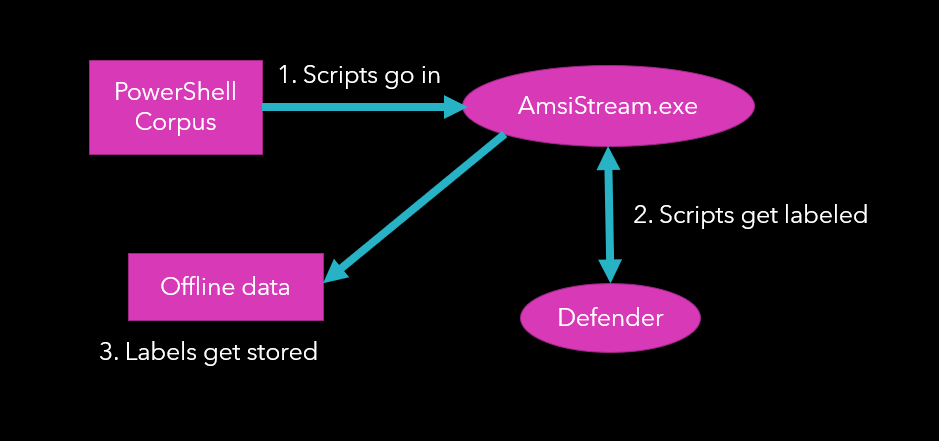


(The script to collect outputs is included in this lab, `collect.py`. Additionally, the sample Windows AmsiStream project does not include `amsi.h` which contains the code responsible for loading AMSI, that file has also been included in the workshop folder.)

As Bill and Ted say, "Excellent!". Go ahead and browse to either `data\clean` or `data\dirty`, you will notice that each file isn't named anything normal like `malware.ps1`, during processing in `collect.py` the MD5 hash is calculated and is used to name the file. This makes it easy to remove duplicate files from our dataset without having to rely on the original name of the file. 

Next, let's take a look at inside a file, open any random file under `data\clean` or `data\dirty`. Each file has all the relevant information attached to the sample - the original filename, MD5 hash, label from Windows Defender, and the base64 encoded script content. When you're finised looking go ahead and close the file.

Keeping data in a structured format makes the rest of the machine learning process much easier. If you are unfamiliar with Python data structures, go ahead a run the below code a few times. In the next section when we start processing the files, the [`split`](https://docs.python.org/3.6/library/stdtypes.html#str.split) method makes it easy for us to create a list using a delimeter of our choosing.

In [ ]:
data = 'Get-Screenshot.ps1,efe0f668d1e4d1a27dcc19055a363c30,Scan result is 32768. IsMalware: 1,ZnVuY3Rpb24gR2V0LVNjcmVlbnNob3QgCnsKICAgIHBhcmFtCiAgICAoCiAgICAgICAgW1BhcmFtZXRlcihNYW5kYXRvcnkgPSAkRmFsc2UpXQogICAgICAgIFtzdHJpbmddCiAgICAgICAgJFJhdGlvCiAgICApCiAgICBBZGQtVHlwZSAtQXNzZW1ibHkgU3lzdGVtLldpbmRvd3MuRm9ybXM7CiAgICAkU2NyZWVuQm91bmRzID0gW1dpbmRvd3MuRm9ybXMuU3lzdGVtSW5mb3JtYXRpb25dOjpWaXJ0dWFsU2NyZWVuOwogICAgJFNjcmVlbnNob3RPYmplY3QgPSBOZXctT2JqZWN0IERyYXdpbmcuQml0bWFwICRTY3JlZW5Cb3VuZHMuV2lkdGgsICRTY3JlZW5Cb3VuZHMuSGVpZ2h0OwogICAgJERyYXdpbmdHcmFwaGljcyA9IFtEcmF3aW5nLkdyYXBoaWNzXTo6RnJvbUltYWdlKCRTY3JlZW5zaG90T2JqZWN0KTsKICAgICREcmF3aW5nR3JhcGhpY3MuQ29weUZyb21TY3JlZW4oICRTY3JlZW5Cb3VuZHMuTG9jYXRpb24sIFtEcmF3aW5nLlBvaW50XTo6RW1wdHksICRTY3JlZW5Cb3VuZHMuU2l6ZSk7CiAgICAkRHJhd2luZ0dyYXBoaWNzLkRpc3Bvc2UoKTsKICAgICRtcyA9IE5ldy1PYmplY3QgU3lzdGVtLklPLk1lbW9yeVN0cmVhbTsKICAgIGlmICgkUmF0aW8pIHsKICAgIAl0cnkgewogICAgCQkkaVF1YWwgPSBbY29udmVydF06OlRvSW50MzIoJFJhdGlvKTsKICAgIAl9IGNhdGNoIHsKICAgIAkJJGlRdWFsPTgwOwogICAgCX0KICAgIAlpZiAoJGlRdWFsIC1ndCAxMDApewogICAgCQkkaVF1YWw9MTAwOwogICAgCX0gZWxzZWlmICgkaVF1YWwgLWx0IDEpewogICAgCQkkaVF1YWw9MTsKICAgIAl9CiAgICAJJGVuY29kZXJQYXJhbXMgPSBOZXctT2JqZWN0IFN5c3RlbS5EcmF3aW5nLkltYWdpbmcuRW5jb2RlclBhcmFtZXRlcnM7CgkJCSRlbmNvZGVyUGFyYW1zLlBhcmFtWzBdID0gTmV3LU9iamVjdCBEcmF3aW5nLkltYWdpbmcuRW5jb2RlclBhcmFtZXRlciAoW1N5c3RlbS5EcmF3aW5nLkltYWdpbmcuRW5jb2Rlcl06OlF1YWxpdHksICRpUXVhbCk7CgkJCSRqcGVnQ29kZWMgPSBbRHJhd2luZy5JbWFnaW5nLkltYWdlQ29kZWNJbmZvXTo6R2V0SW1hZ2VFbmNvZGVycygpIHwgV2hlcmUtT2JqZWN0IHsgJF8uRm9ybWF0RGVzY3JpcHRpb24gLWVxICJKUEVHIiB9CgkJCSRTY3JlZW5zaG90T2JqZWN0LnNhdmUoJG1zLCAkanBlZ0NvZGVjLCAkZW5jb2RlclBhcmFtcyk7CgkJfSBlbHNlIHsKICAgIAkkU2NyZWVuc2hvdE9iamVjdC5zYXZlKCRtcywgW0RyYXdpbmcuSW1hZ2luZy5JbWFnZUZvcm1hdF06OlBuZyk7CiAgICB9CiAgICAkU2NyZWVuc2hvdE9iamVjdC5EaXNwb3NlKCk7CiAgICBbY29udmVydF06OlRvQmFzZTY0U3RyaW5nKCRtcy5Ub0FycmF5KCkpOwp9CkdldC1TY3JlZW5zaG90'
data = data.split(',')
data[1] # replace 0 with 1, 2, or 3.

Items in a list are referenced by index, and there are some neat operations we can perform. In the below example, we create a new list with items from index 1 through the end of the list.

In [ ]:
data[1:]

We can also reference items in a list in reverse order. 

In [ ]:
script_content = data[-1] # last item in the list
script_content

When working with data there will inevitably be some oddities. In this dataset there were a number of scripts that were written in Cryllic and generated encoding errors. We simply ignored those scripts, which may have been a terrible idea, and we will get into why later on. For now, let's decode this malicious base64.

In [ ]:
import base64
base64.b64decode(script_content)

Hmmm, that't not very nice to look at, can you use `split()` to make it look a little nicer?

In [ ]:
base64.b64decode(script_content).decode().lower()

### Solution

In [ ]:
base64.b64decode(script_content).decode().lower().split('\n') # Solution

Much better.

The script simply collects a screenshot - what is so malicious about that? We know that machine learning is good at building relationships between data, according to Defender, there is something malicous in this script. To find out what that might be, we should look at what all the malcious scripts have in common. 

To do this we're going to use the familar list structure, and we're also going to introduce dictionaries. Dictionaries store key-value pairs, much like a real dictionary where a word is followed by a defintion. They are created using curly brackets `my_dictionary = {}`. Instead of using an index to reference items, you can use the key value. For example,

In [ ]:
my_dictionary = {} # create an empty dictionary
my_dictionary['key'] = 'value' # add some data

my_dictionary['key'] # print the value inside 'key'

Dictionaries are flexible structures and can store any object you like.

In [ ]:
my_dictionary['key_list'] = ['A', 'list', 'of', 'things'] # add list to the dictionary

my_dictionary['key_list'] # print the list

Including other dictionaries!

In [ ]:
my_dictionary['key_dict'] = {} # add a dictionary to the dictionary
my_dictionary['key_dict']['nested_dict'] = 'nested_value' # give the nested dictionary a value

my_dictionary['key_dict']['nested_dict'] # print the value in the nested dictionary

And the whole thing looks like...

In [ ]:
my_dictionary

A dictionary structure will help us keep a unique list of all the words and the number of occurences in the malicious scripts. Before we process ALL the scripts, we should get just get ONE example working. Processing large datasets takes time and it is generally a good idea to make sure everything is the way you want it before getting too far down the road.

In [ ]:
decoded_content = base64.b64decode(script_content).decode().lower().split('\n') # script content from above

all_words = {} # create the dictionary

for line in decoded_content:
    temp_words = line.split(' ') # split the content into a list
    
    for word_index in temp_words:
        if len(word_index) > 0: # make sure there is a token
            
            if word_index not in all_words.keys():
                all_words[word_index] = 1 # note the first instance of the word
                
            elif word_index in all_words.keys():
                all_words[word_index] = all_words[word_index] # ?
                
            else:
                print(word_index) # print the problem word

No errors? Nice, let's see if that worked. Hmmm, something isn't quite right...can you tell what it is?

In [ ]:
all_words 

### Solution

In [ ]:
decoded_content = base64.b64decode(script_content).decode().lower().split('\n') # script content from above

all_words = {} # create the dictionary

for line in decoded_content:
    temp_words = line.split(' ') # split the content into a list
    
    for word_index in temp_words:
        if len(word_index) > 0: # make sure there is a token
            
            if word_index not in all_words.keys():
                all_words[word_index] = 1 # note the first instance of the word
                
            elif word_index in all_words.keys():
                all_words[word_index] = all_words[word_index] + 1 # if the word is already in our dictionary, add one
                
            else:
                print(word_index) # print the problem word
                
all_words

If you were able to solve the problem above - the below code will sort the dictionary by value.

In [ ]:
{k: v for k, v in sorted(all_words.items(), key=lambda item: item[1], reverse=True)}

There is a lot of punction and other nonsense in our output, but whatever, let's do this thing. Read through the code below or just execute it, like the wild person you are.  

In [ ]:
import os

malware_data = './data/dirty'

all_words = {} # reset the dictionary

for script in os.listdir(malware_data):
    with open(f'{malware_data}/{script}', 'r') as f:
        data = f.read().split(',')

        # decode the script
        decoded_data = base64.b64decode(data[3].encode()).decode().lower()

        # make a list
        split_data = decoded_data.split()

        for line in split_data:
            temp_words = line.split(' ') # split the content into a list

            for word_index in temp_words:
                if len(word_index) > 0: # make sure there is a token

                    if word_index not in all_words.keys():
                        all_words[word_index] = 1 # note the first instance of the word

                    elif word_index in all_words.keys():
                        all_words[word_index] = all_words[word_index] + 1 # if the word is already in our dictionary, note the presence 

                    else:
                        print(word_index) # print the problem word

That took FOREVER. Alright, let's take a look to see what came out on the otherside (Get your scrolling finger ready).

In [ ]:
sorted_words = {k: v for k, v in sorted(all_words.items(), key=lambda item: item[1], reverse=True)}
sorted_words

In [ ]:
len(sorted_words.keys()) 

There are ~70k unique words in our dictionary. However, there are a lot of numbers showing up which isn't really what we're looking for. The good news though, is that panning through the list there are some known malicious words towards the top. Let's clean it up to get an even better view of our malicious scripts

In [ ]:
import re

explore_list = [] # create new list

for k, v in sorted_words.items():
    if re.findall(r'[\.#+()|{}=\d]+', k): # removed punctuation and numbers
        continue
    
    explore_list.append(f'{k} : {v}') # add everything else to the new list

explore_list[:100] # Get the top 100 words, try explore_list[100:200] 

That's a little better. 

These are the words that occur most in scripts that Windows Defender labeled as malicious. Do you agree? Try Googling some of the words, hopefully what comes up are known malicious PowerShell scripts! Some of these tokens however are also likely in the clean scripts. My guess as to why Defender labeled our example "Get-Screenshot" script was the `tobase64string`.

We could stop here and you could write your malicious script to ensure it doesn't contain any words from a known malicious script. Alternatively, you could repeat the above process for clean scripts and only use words from those. I think that could probably work given the basis for these insights come from Windows Defender, even some simple data collection and analysis, coupled with domain knowledge can take you a long way. Pff, which is okaaayyy I guess, but that's not why we're here. There's a better way to model these words with machine learning!

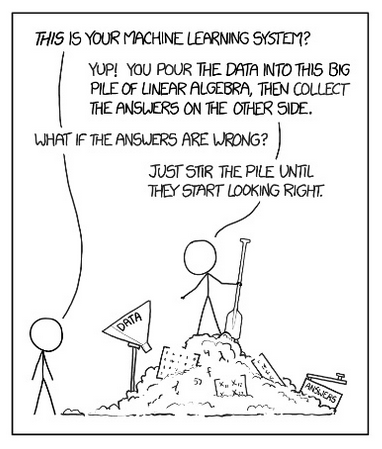

# 4. Machine Learning
In the previous section we became familiar with our data and even came up with a round about way to gain insights into Windows Defender. However, our solution wasn't scalable, or particuarly telling. MOREOVER, this is a machine learning workshop and so far there hasn't been any machine learning. Alright, fine, we'll do some machine learning, but we need to think through a few problems.  

1. Algorithms don't understand words, we need a way to represent words as numbers so that math can make sense of our data. 
2. There are 380k clean scripts and only 1153 malicious scripts, making for an extremely unbalanced dataset. With such a large imbalance, if we used our previous method we potentially dilute our malicious word counts.
3. Figure out how to introduce our data into the model. 
4. Devise a way to prove that the attack worked (aka profit).

Even in those steps there are sub-steps galore. Machine learning has a lot of moving parts and even the most basic model requires some serious engineering.

## 4.1 Data Representation
Data representation is exactly what it sounds like, and is the crucial step of processing the data such that it accurately represents the categories that you want to model. While the media and the illuminati would have you believe that any data can be fed into any algorithm and useful stuff will come out the other end, that is sadly not the case. For example, if you wanted to build a classification model that classified pictures of apples and bananas, you would want only the most archetype fruit of each kind. If there were enough bananas that looked like apples, your model would have a hard time differetiating them in the real world. Don't sweat the math (too much), algorithms largely take care of themselves!

We've already played with some data representation above when we gathered the word counts for each script earlier. Do you remember when we split the script into separate words? The formal description of that is called "tokenization", and it is the preliminary step before representing text as numbers in a vector.

What's the vector, Victor? To create a tokenizer, import the Tokenizer class and instantiate.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer() # Instantiate the tokenizer

So now what? Time to vectorize some content!

In [ ]:
corpus = ['My cat likes mittens',
          'Your cat is small',
          'Six cats will never fit in there',
          'Did you bring your mittens?']

tokenizer.fit_on_texts(corpus)
tokenizer.word_index

Each item in the list represents a separate document. Notice that `word_index` keeps a sequential list of all words that occur in each document. The vector for the `My cat likes mittens` would look like...

In [ ]:
tokenizer.texts_to_sequences([corpus[0]])

Can you figure out how to go backwards, what does `[15, 8, 7, 9, 12, 13, 14]` say? What about `[3, 2, 12]`

In [ ]:
tokenizer.sequences_to_texts([[8, 7, 9]])

There are a number of ways to represent text in a vector, but for this lab well will focus on One-Hot encoding. One-Hot encoding creates vectors that are the length of the vocabulary, and for a given document, the presence of a token is represented with a 1, otherwise a 0. Check it out.

In [ ]:
len(tokenizer.word_index) # length of the vocab

In [ ]:
tokenizer.texts_to_matrix(corpus, mode='binary')[0] # the first one-hot encoded sequence

What about our test sentence from above? Let's do a few iterations and examine the output.

In [ ]:
tokenizer.texts_to_matrix(['six small cats'], mode='binary') # test one-hot encoded sequence

In [ ]:
tokenizer.texts_to_matrix(['six small mittens'], mode='binary') # test one-hot encoded sequence

In [ ]:
tokenizer.texts_to_matrix(['mittens small six'], mode='binary') # test one-hot encoded sequence

Is it starting to make some sense? 

## 4.2 Vectorizing the Scripts
Now you know what tokenization is all about, we can prepare our PowerShell corpus. First, there is one more data structure that we will discover, named tuples. You can think of a named tuple as an immutable class. This means you can reference a variable inside a tuple by name, rather than by index in lists or by key in dictionaries. 

First you import the `nametuple` class, then you create a namedtuple as you would instantiate a class - `MyNamedTuple = namedtuple('MyTuple', 'var1, var2')`. From then on you can create new named tuples and set their contents to whatever you like.

In [ ]:
from collections import namedtuple

MyNamedTuple = namedtuple('MyTuple', 'var1, var2') # Create the object
temp_tuple = MyNamedTuple(var1='text1', var2='text2') # Create a new tuple

temp_tuple.var1

Read through the code below, you should be familiar with most of it by now. There is one part of this code we haven't covered, but you're a pro, you can figure out what it does. After you're done reading go ahead and run it. It might take a few minutes depending what kind of potato you're running.

In [ ]:
malware_data = './data/dirty'
clean_data = './data/clean'

punc_re = re.compile(r'[\_\-,;@#?!&$"(){}<>\'\[\]\\\\]+\ *') # remove punctuation 

tokenizer = Tokenizer() # reset the tokenizer

all_texts = [] # create a primary list to hold all the named tuples
docs = [] # create a list to hold all documents for tokenizing

ScoredObject = namedtuple('Scored', 'script_content, label')

for script in os.listdir(malware_data):
    with open(f'{malware_data}/{script}', 'r') as f:
        data = f.read().split(',')

        # decode the script
        decoded_data = base64.b64decode(data[3].encode()).decode().lower()

        # remove punctuation - redo this - or have them play with tokenization
        stripped_data = re.sub(punc_re, ' ', decoded_data)

        # make a list
        split_data = stripped_data.split()

        # check it twice
        uniq_data = list(set(split_data))

        # add to list of docs to be tokenized. I assume this makes tokenization faster...but I have no evidence for this 
        docs.append(uniq_data)

        # Create the training struct while we're here.
        jdata = ' '.join(uniq_data)
        temp = ScoredObject(script_content=jdata, label=1) # Add the malicious label
        all_texts.append(temp)
        

# do the clean scripts
for script in os.listdir(clean_data)[:1153]:
    with open(f'{clean_data}/{script}', 'r') as f:
        data = f.read().split(',')

        # decode the script
        decoded_data = base64.b64decode(data[3].encode()).decode().lower()

        # remove punctuation - redo this - or have them play with tokenization
        stripped_data = re.sub(punc_re, ' ', decoded_data)

        # make a list
        split_data = stripped_data.split()

        # check it twice
        uniq_data = list(set(split_data))

        # add to list of docs to be tokenized, I assume this makes tokenization faster...but I have no evidence for this 
        docs.append(uniq_data)

        # Create the training struct while we're here.
        jdata = ' '.join(uniq_data)
        temp = ScoredObject(script_content=jdata, label=0) # Add the clean label
        all_texts.append(temp)

# build a vocab
tokenizer.fit_on_texts(docs)


A few things you may have noticed above. Firstly, remember earlier when we talked about how unbalanced the dataset set is in terms of clean scripts (380k) vs dirty scripts (1153)? Did you notice how we "solved" it? Here's a live action replay...

```python
# do the clean scripts
for script in os.listdir(clean_data)[:1153]:
    with open(f'{clean_data}/{script}', 'r') as f:
        data = f.read().split(',')
```

I put solved in quotes because simply selecting the first 1153 scripts is the most ludacris way to "balance" the dataset. We could rewrite the function so that it chooses 1153 random scripts, or we could do a million things. However, now is not the time. Machine learning is about quickly iterating through ideas and experiments, and to do that effectively you need a pipeline. We haven't even got to building the model yet, so there is little point in making manual changes to balance the dataset before we know how it will affect the model. For now, enjoy your tokenizing handywork and explore some of the tokenized scripts. If you're unhappy with it, feel free to change `punc_re`.

In [ ]:
docs[0]

## 4.3 Algos and What Not
We're here! We made it. Finally, some machine learning! If you're not familiar with machine learning, I highly recommend this [little video series](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi) from 3Blue1Brown. We'll cover some of the basics here, but it is an excellent series. Anyway, back to the task at hand, there was a piece of code in the last section that we actually hadn't covered.

```python
# Create the training struct while we're here.
jdata = ' '.join(uniq_data)
temp = ScoredObject(script_content=jdata, label=1) # Add the malicious label
all_texts.append(temp)
```
In this little code block we take the unique words in the script and the score, and create a namedtuple. This is in preparation for introducing the data to the algo. Yeah, you're cool now, you can say "algo". 

Hmm. Inputs, activations, and loss. Where. To. Start.

Neural networks are made up of nodes organized in to their various layers.

- Input layers represent input data (one-hot encoded text)
- Hidden layers represent an activation function
- Output layer is the result of the network. The classification or prediction (malware vs not malware)

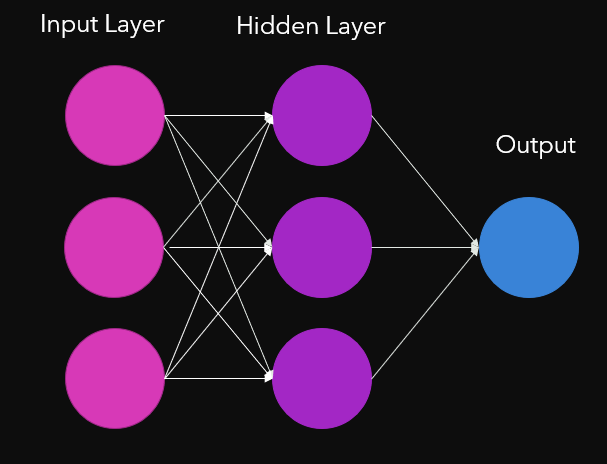

Inputs move "forward" (from left to right in picture terms) through the network until the output layer is reached, layers are connected by weights. Weights modulate the inputs such that when they have been properly updated they cause the network to fire in a particular way. Input nodes pass their values to the hidden nodes. Hidden nodes calculate the weighted sum of the inputs before being put through an "activation" function. The outputs from a hidden layer are simply passed on to the next, until the final output layer is reached.  During training, when the output is reached, the loss is calculated. The loss is represents how "well" the network did at whatever task.  With a large loss, the network didn't do a good job, however a small loss suggests the network was close to the ground-truth label. A network "learns" by minimizing the loss, most commonly though gradient descent. You will be familiar with a gradient if you've ever walked up or down a hill. Gradient descent simply tells the network which way, up or down, the network needs to go in order to minimize the loss. Backpropogation is responsible for making the adjustments to each weight in proportion to its affect on the error.

## 4.4 Model Clay
We briefly covered one-hot encoding. Do you remember what and/or how? Go a head and one-hot encode all the documents. 

In [ ]:
# tokenize all the docs at once

### Solution

In [ ]:
text_matrix = tokenizer.texts_to_matrix(docs)

Next, we need labels. List comprehension and namedtuples in all their glory!

In [ ]:
score_matrix = np.array([e.score for e in all_texts])

Life is so confusing, you know. Tabs vs Spaces, Nano vs VSCode, Messi vs ...that other guy. Machine learning frameworks are no different. Personally, I prefer Keras...waiting for someone to say "ACTUALLY". It's true Keras is not a machine learning framework, it's a wrapper for tensorflow. Still, the integration and the convieniences it brings are really nice. Do you lose some flexibility over PyTorch? Maybe, but that doesn't mean flexibility doesn't exist. APIs are about abstracting away the mess, so while on the surface Keras feels simple, once you dig in a little bit you'll find all the complexity you want. Ultimately, no matter what framework you choose, having a grounding in the fundementals will take you much further than any one framework. 

In [ ]:
model = Sequential()
model.add(Dense(64, activation='sigmoid', input_dim=text_matrix.shape[1]))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mse', optimizer='adam', metrics=['acc'])

## Evaluation

In [ ]:
mse, acc = model.evaluate(x_test, y_test)
print(f'[+] Mean score error: {mse}')
print(f'[+] Accuracy: {acc}')

## Extracting Information
This is where I leave you. I know I know, we've come so far. The only thing left is to try absolutely every possible combination of tokens and keep a running sum of predictions.as a parting gift, `insights.xlsx` contains the first version of the results. It's up to you to take what you learned here and improve on them! 

In [ ]:
insights = {}

with alive_bar(len(text_matrix), bar='blocks') as bar:
    for sample in text_matrix:
        bar()
        base_prediction = model.predict(np.array([sample]))[0][0]

        for i,word_is_set in enumerate(sample):
            if i is 0 or not word_is_set: continue # first index is reserved
            
            word = tokenizer.index_word[i]
            alt_sample = np.copy(sample)
            alt_sample[i] = 0
            new_prediction = model.predict(np.array([alt_sample]))[0][0]            

            if word not in insights:
                insights[word] = [0, 0]

            insights[word][0] += 1
            insights[word][1] += (base_prediction - new_prediction)

insights = dict([(k, i[1] / i[0]) for k,i in insights.items()])

sights = sorted(insights.items(), key=lambda x: x[1], reverse=True) 

Thanks for attending. Join us @